# 02 - Classificando patologias em toras usando combinação de `OTSU_threshold + LBP + SVM`

## Importando bibliotecas

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from zipfile import ZipFile
from skimage import io
from skimage.filters import threshold_otsu
from skimage.feature import local_binary_pattern

# Parâmetros do LBP
METHOD = 'nri_uniform'
RADIUS = 1
N_POINTS = 8

TARGET_NAMES = {'normal': 0,
                'broca':1,
                'fissura': 2,
                'musgo': 3}

## Processando imagens

In [2]:
path_dict = {name: [] for name in TARGET_NAMES}

with ZipFile('./patologias_toras.zip') as zip_file:
  for path in zip_file.namelist():
    # a pasta de cada amostra é o segundo elemento do split
    folder = path.split('/')[1]
    # Separando amostras por classe
    if folder in TARGET_NAMES:
      path_dict[folder].append(f'./patologias_toras.zip/{path}')


# Mostrando quantidade de amostras por classe
qtd_amostras_p_classe = []
for target in path_dict:
  n_amostras = len(path_dict[target])
  print(f'{target}: {n_amostras} amostras')

  qtd_amostras_p_classe.append(n_amostras)

N_MIN_DE_AMOSTRAS = min(qtd_amostras_p_classe)
amostra = []

for target_name in TARGET_NAMES:
  path_list = path_dict[target_name]
  path_list_slice = path_list[:N_MIN_DE_AMOSTRAS]
  
  for path in path_list_slice:
    img = io.imread(path, as_gray=True)
    
    img_otsu = img >= threshold_otsu(img)

    lbp = local_binary_pattern(image=img_otsu, P=N_POINTS, R=RADIUS, method=METHOD).flatten()
    
    hist = pd.Series(lbp).value_counts().sort_index()
    arr = np.zeros(59)
    for i in hist.index:
      arr[int(i)] = hist[i]

    df = pd.DataFrame(data=[arr])
    df['target'] = TARGET_NAMES[target_name]
    amostra.append(df)

data = pd.concat(amostra, ignore_index=True)
data.to_csv('./csvs/otsu_lbp_toras.csv')
data

normal: 107 amostras
broca: 90 amostras
fissura: 109 amostras
musgo: 111 amostras


,0,1,2,3,4,5,6,7,8,9,...,50,51,52,53,54,55,56,57,58,target
0,1156.0,1339.0,0.0,1239.0,0.0,1441.0,0.0,1218.0,0.0,0.0,...,0.0,1008.0,0.0,999.0,0.0,1005.0,0.0,246617.0,9016.0,0
1,947.0,1211.0,0.0,1090.0,0.0,1228.0,0.0,1007.0,0.0,0.0,...,0.0,2372.0,0.0,2127.0,0.0,2150.0,0.0,208973.0,13000.0,0
2,961.0,1310.0,0.0,865.0,0.0,1316.0,0.0,824.0,0.0,0.0,...,0.0,1455.0,0.0,1549.0,0.0,1380.0,0.0,225070.0,9771.0,0
3,918.0,1600.0,0.0,1365.0,0.0,1612.0,0.0,1284.0,0.0,0.0,...,0.0,2873.0,0.0,2995.0,0.0,2847.0,0.0,229565.0,16019.0,0
4,993.0,1836.0,0.0,1646.0,0.0,1818.0,0.0,1592.0,0.0,0.0,...,0.0,3020.0,0.0,3200.0,0.0,3094.0,0.0,217176.0,19958.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
355,44.0,78.0,0.0,64.0,0.0,83.0,0.0,49.0,0.0,0.0,...,0.0,211.0,0.0,215.0,0.0,185.0,0.0,13171.0,527.0,3
356,43.0,73.0,0.0,79.0,0.0,81.0,0.0,93.0,0.0,0.0,...,0.0,618.0,0.0,729.0,0.0,625.0,0.0,43644.0,997.0,3
357,22.0,41.0,0.0,26.0,0.0,43.0,0.0,27.0,0.0,0.0,...,0.0,110.0,0.0,141.0,0.0,81.0,0.0,22414.0,270.0,3
358,301.0,347.0,0.0,283.0,0.0,346.0,0.0,285.0,0.0,0.0,...,0.0,293.0,0.0,307.0,0.0,290.0,0.0,57361.0,1793.0,3


In [3]:
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import (accuracy_score,
                             classification_report,
                             confusion_matrix,
                             f1_score,
                             plot_confusion_matrix)

## Realizando 30 rodadas de classificação

Rodada 0	-	Seed 7876
              precision    recall  f1-score   support

      normal       0.77      0.68      0.72        25
       broca       0.71      0.71      0.71        28
     fissura       0.77      0.92      0.84        26
       musgo       0.96      0.90      0.93        29

    accuracy                           0.81       108
   macro avg       0.81      0.80      0.80       108
weighted avg       0.81      0.81      0.80       108



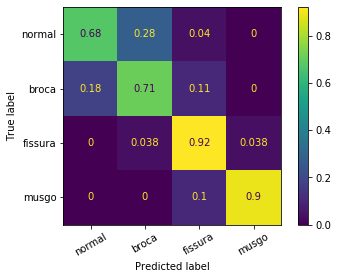

Rodada 1	-	Seed 845
              precision    recall  f1-score   support

      normal       0.93      0.87      0.90        31
       broca       0.74      0.88      0.81        26
     fissura       0.82      0.77      0.79        30
       musgo       0.90      0.86      0.88        21

    accuracy                           0.84       108
   macro avg       0.85      0.84      0.84       108
weighted avg       0.85      0.84      0.84       108



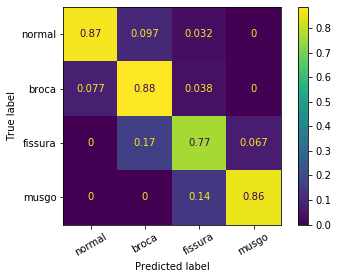

Rodada 2	-	Seed 2520
              precision    recall  f1-score   support

      normal       0.75      0.75      0.75        24
       broca       0.58      0.58      0.58        24
     fissura       0.68      0.83      0.75        23
       musgo       1.00      0.86      0.93        37

    accuracy                           0.77       108
   macro avg       0.75      0.76      0.75       108
weighted avg       0.78      0.77      0.77       108



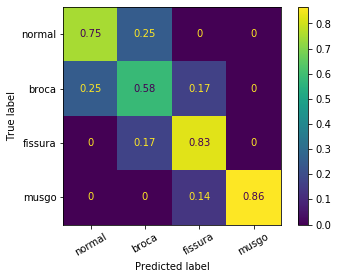

Rodada 3	-	Seed 7932
              precision    recall  f1-score   support

      normal       0.74      0.87      0.80        23
       broca       0.70      0.66      0.68        29
     fissura       0.75      0.75      0.75        28
       musgo       0.92      0.86      0.89        28

    accuracy                           0.78       108
   macro avg       0.78      0.78      0.78       108
weighted avg       0.78      0.78      0.78       108



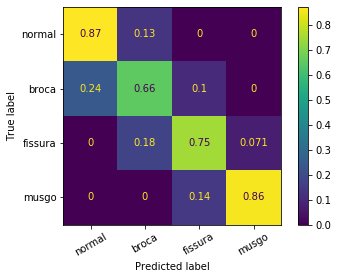

Rodada 4	-	Seed 4873
              precision    recall  f1-score   support

      normal       0.76      0.93      0.84        28
       broca       0.85      0.61      0.71        28
     fissura       0.77      0.96      0.86        25
       musgo       1.00      0.85      0.92        27

    accuracy                           0.83       108
   macro avg       0.85      0.84      0.83       108
weighted avg       0.85      0.83      0.83       108



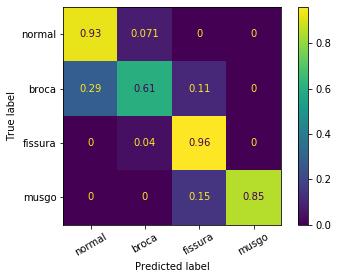

Rodada 5	-	Seed 226
              precision    recall  f1-score   support

      normal       0.93      0.88      0.90        32
       broca       0.78      0.89      0.83        28
     fissura       0.63      0.85      0.72        20
       musgo       1.00      0.68      0.81        28

    accuracy                           0.82       108
   macro avg       0.84      0.82      0.82       108
weighted avg       0.85      0.82      0.83       108



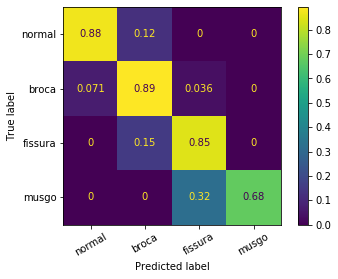

Rodada 6	-	Seed 6616
              precision    recall  f1-score   support

      normal       0.79      0.76      0.78        25
       broca       0.74      0.69      0.71        29
     fissura       0.74      0.89      0.81        28
       musgo       0.91      0.81      0.86        26

    accuracy                           0.79       108
   macro avg       0.80      0.79      0.79       108
weighted avg       0.79      0.79      0.79       108



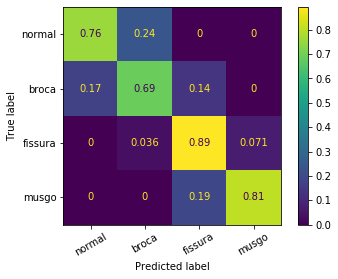

Rodada 7	-	Seed 5687
              precision    recall  f1-score   support

      normal       0.85      0.85      0.85        26
       broca       0.81      0.81      0.81        27
     fissura       0.78      0.88      0.82        32
       musgo       0.89      0.74      0.81        23

    accuracy                           0.82       108
   macro avg       0.83      0.82      0.82       108
weighted avg       0.83      0.82      0.82       108



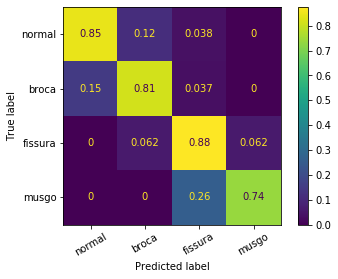

Rodada 8	-	Seed 3413
              precision    recall  f1-score   support

      normal       0.92      0.83      0.87        29
       broca       0.79      0.88      0.84        26
     fissura       0.77      0.83      0.80        24
       musgo       0.89      0.83      0.86        29

    accuracy                           0.84       108
   macro avg       0.84      0.84      0.84       108
weighted avg       0.85      0.84      0.84       108



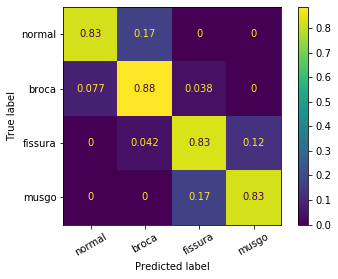

Rodada 9	-	Seed 5974
              precision    recall  f1-score   support

      normal       0.96      0.86      0.91        28
       broca       0.76      0.83      0.79        23
     fissura       0.68      0.86      0.76        22
       musgo       0.97      0.83      0.89        35

    accuracy                           0.84       108
   macro avg       0.84      0.84      0.84       108
weighted avg       0.86      0.84      0.85       108



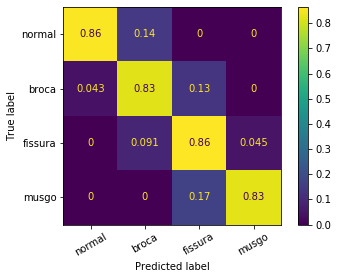

Rodada 10	-	Seed 2153
              precision    recall  f1-score   support

      normal       0.86      0.68      0.76        28
       broca       0.68      0.77      0.72        30
     fissura       0.76      0.79      0.77        28
       musgo       0.87      0.91      0.89        22

    accuracy                           0.78       108
   macro avg       0.79      0.79      0.78       108
weighted avg       0.79      0.78      0.78       108



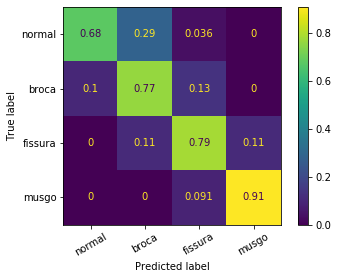

Rodada 11	-	Seed 4189
              precision    recall  f1-score   support

      normal       0.90      0.76      0.83        34
       broca       0.62      0.62      0.62        24
     fissura       0.68      0.90      0.78        21
       musgo       0.96      0.90      0.93        29

    accuracy                           0.80       108
   macro avg       0.79      0.80      0.79       108
weighted avg       0.81      0.80      0.80       108



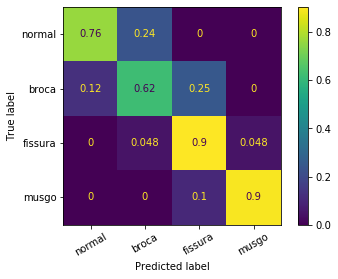

Rodada 12	-	Seed 4078
              precision    recall  f1-score   support

      normal       0.78      0.93      0.85        27
       broca       0.71      0.69      0.70        29
     fissura       0.67      0.77      0.71        26
       musgo       1.00      0.69      0.82        26

    accuracy                           0.77       108
   macro avg       0.79      0.77      0.77       108
weighted avg       0.79      0.77      0.77       108



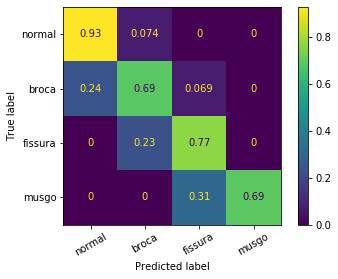

Rodada 13	-	Seed 6334
              precision    recall  f1-score   support

      normal       0.84      0.70      0.76        23
       broca       0.57      0.76      0.65        21
     fissura       0.78      0.75      0.76        28
       musgo       0.97      0.92      0.94        36

    accuracy                           0.80       108
   macro avg       0.79      0.78      0.78       108
weighted avg       0.82      0.80      0.80       108



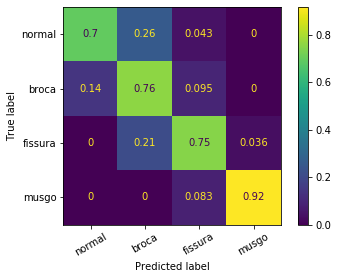

Rodada 14	-	Seed 4927
              precision    recall  f1-score   support

      normal       0.72      0.78      0.75        23
       broca       0.74      0.68      0.71        34
     fissura       0.70      0.79      0.74        29
       musgo       0.84      0.73      0.78        22

    accuracy                           0.74       108
   macro avg       0.75      0.74      0.75       108
weighted avg       0.75      0.74      0.74       108



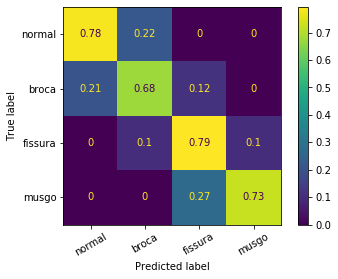

Rodada 15	-	Seed 3857
              precision    recall  f1-score   support

      normal       0.88      0.92      0.90        25
       broca       0.89      0.83      0.86        29
     fissura       0.76      0.96      0.85        23
       musgo       1.00      0.84      0.91        31

    accuracy                           0.88       108
   macro avg       0.88      0.89      0.88       108
weighted avg       0.89      0.88      0.88       108



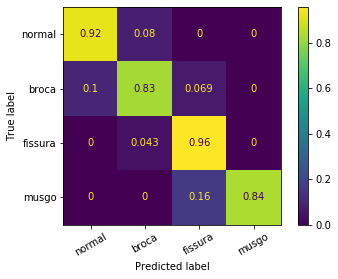

Rodada 16	-	Seed 6719
              precision    recall  f1-score   support

      normal       0.97      0.94      0.95        32
       broca       0.86      0.89      0.88        28
     fissura       0.76      0.83      0.79        23
       musgo       0.91      0.84      0.87        25

    accuracy                           0.88       108
   macro avg       0.88      0.87      0.87       108
weighted avg       0.88      0.88      0.88       108



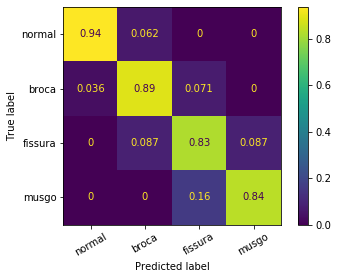

Rodada 17	-	Seed 2732
              precision    recall  f1-score   support

      normal       1.00      0.90      0.95        30
       broca       0.85      0.92      0.88        25
     fissura       0.72      0.88      0.79        24
       musgo       0.92      0.79      0.85        29

    accuracy                           0.87       108
   macro avg       0.87      0.87      0.87       108
weighted avg       0.88      0.87      0.87       108



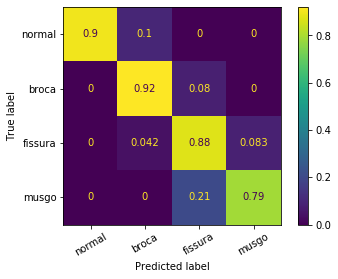

Rodada 18	-	Seed 5214
              precision    recall  f1-score   support

      normal       0.80      0.87      0.83        23
       broca       0.67      0.72      0.69        25
     fissura       0.69      0.69      0.69        32
       musgo       0.92      0.79      0.85        28

    accuracy                           0.76       108
   macro avg       0.77      0.77      0.76       108
weighted avg       0.77      0.76      0.76       108



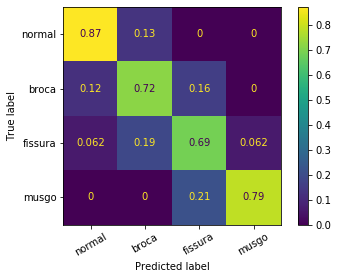

Rodada 19	-	Seed 1585
              precision    recall  f1-score   support

      normal       0.86      0.66      0.75        29
       broca       0.67      0.85      0.75        26
     fissura       0.81      0.85      0.83        26
       musgo       0.96      0.93      0.94        27

    accuracy                           0.81       108
   macro avg       0.83      0.82      0.82       108
weighted avg       0.83      0.81      0.82       108



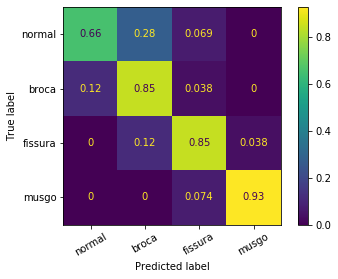

Rodada 20	-	Seed 7044
              precision    recall  f1-score   support

      normal       0.89      0.83      0.86        30
       broca       0.72      0.72      0.72        25
     fissura       0.77      0.86      0.81        28
       musgo       0.96      0.92      0.94        25

    accuracy                           0.83       108
   macro avg       0.84      0.83      0.83       108
weighted avg       0.84      0.83      0.83       108



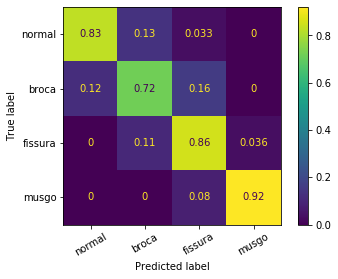

Rodada 21	-	Seed 6967
              precision    recall  f1-score   support

      normal       0.83      0.87      0.85        23
       broca       0.62      0.83      0.71        24
     fissura       0.83      0.63      0.72        30
       musgo       0.93      0.87      0.90        31

    accuracy                           0.80       108
   macro avg       0.80      0.80      0.80       108
weighted avg       0.81      0.80      0.80       108



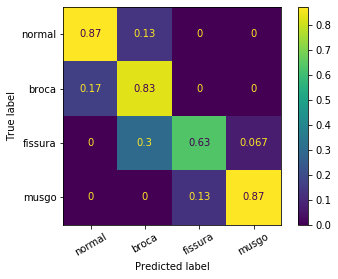

Rodada 22	-	Seed 2210
              precision    recall  f1-score   support

      normal       0.87      0.87      0.87        30
       broca       0.83      0.71      0.77        28
     fissura       0.72      0.92      0.81        25
       musgo       0.95      0.84      0.89        25

    accuracy                           0.83       108
   macro avg       0.84      0.84      0.83       108
weighted avg       0.84      0.83      0.83       108



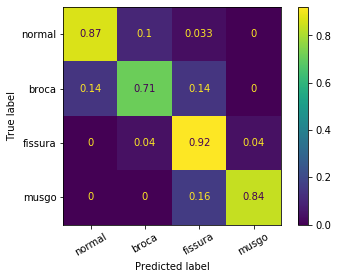

Rodada 23	-	Seed 5308
              precision    recall  f1-score   support

      normal       0.86      0.78      0.82        32
       broca       0.72      0.72      0.72        32
     fissura       0.70      0.86      0.78        22
       musgo       1.00      0.91      0.95        22

    accuracy                           0.81       108
   macro avg       0.82      0.82      0.82       108
weighted avg       0.82      0.81      0.81       108



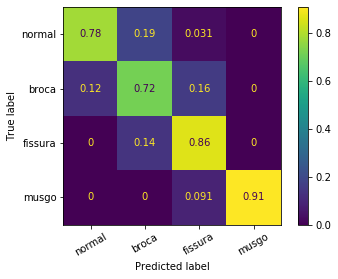

Rodada 24	-	Seed 231
              precision    recall  f1-score   support

      normal       0.81      0.96      0.88        27
       broca       0.88      0.68      0.77        34
     fissura       0.66      0.86      0.75        22
       musgo       0.95      0.80      0.87        25

    accuracy                           0.81       108
   macro avg       0.83      0.83      0.82       108
weighted avg       0.84      0.81      0.81       108



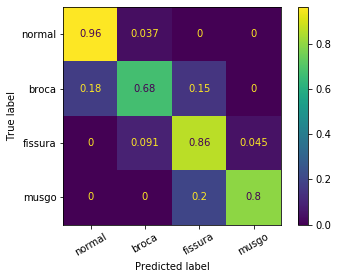

Rodada 25	-	Seed 3501
              precision    recall  f1-score   support

      normal       0.95      0.69      0.80        26
       broca       0.70      0.73      0.72        26
     fissura       0.68      0.93      0.78        27
       musgo       0.96      0.83      0.89        29

    accuracy                           0.80       108
   macro avg       0.82      0.79      0.80       108
weighted avg       0.82      0.80      0.80       108



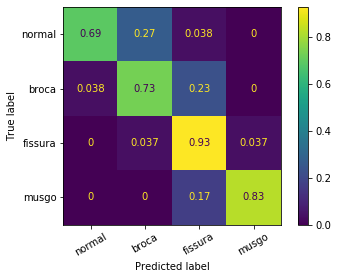

Rodada 26	-	Seed 7645
              precision    recall  f1-score   support

      normal       0.83      0.83      0.83        30
       broca       0.75      0.64      0.69        28
     fissura       0.67      0.82      0.73        22
       musgo       0.93      0.89      0.91        28

    accuracy                           0.80       108
   macro avg       0.79      0.80      0.79       108
weighted avg       0.80      0.80      0.80       108



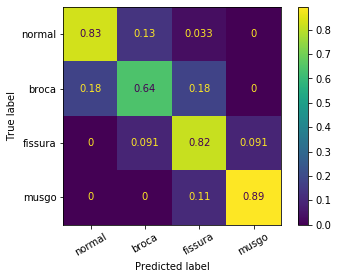

Rodada 27	-	Seed 2202
              precision    recall  f1-score   support

      normal       0.94      0.84      0.89        37
       broca       0.78      0.72      0.75        25
     fissura       0.73      0.92      0.81        26
       musgo       0.89      0.85      0.87        20

    accuracy                           0.83       108
   macro avg       0.84      0.83      0.83       108
weighted avg       0.84      0.83      0.83       108



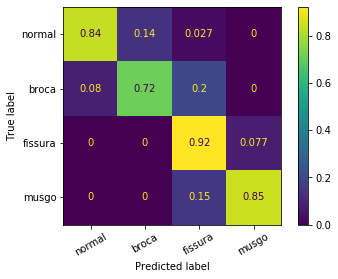

Rodada 28	-	Seed 3182
              precision    recall  f1-score   support

      normal       0.96      0.92      0.94        26
       broca       0.78      0.78      0.78        27
     fissura       0.65      0.80      0.71        25
       musgo       0.96      0.80      0.87        30

    accuracy                           0.82       108
   macro avg       0.84      0.83      0.83       108
weighted avg       0.84      0.82      0.83       108



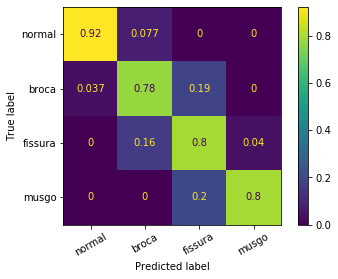

Rodada 29	-	Seed 3042
              precision    recall  f1-score   support

      normal       0.90      0.87      0.88        30
       broca       0.80      0.77      0.79        31
     fissura       0.65      0.85      0.74        20
       musgo       1.00      0.85      0.92        27

    accuracy                           0.83       108
   macro avg       0.84      0.84      0.83       108
weighted avg       0.85      0.83      0.84       108



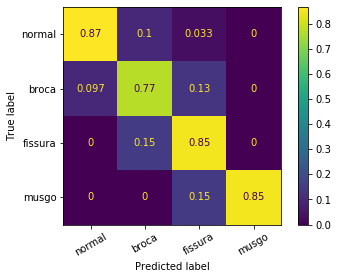

In [4]:
df = pd.read_csv('./csvs/otsu_lbp_toras.csv')
y = df.pop('target').values
X = df.values

# Gerando 30 sementes "aleatórias" dentro do intervalo [0, 8000)
seed_arr = np.random.randint(8000, size=30)

acc_e_f1_por_rodada = []
confu_matrices = []

for rodada, seed in enumerate(seed_arr):
  # separando dados
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=seed)

  clf = make_pipeline(StandardScaler(), SVC()).fit(X_train, y_train)
  y_pred = clf.predict(X_test)
  
  # Adicionando resultados à respectiva lista
  acc_e_f1_por_rodada.append(
    [accuracy_score(y_test, y_pred)]
    + list(f1_score(y_test, y_pred, average=None)))

  confu_matrices.append(
    confusion_matrix(y_test, y_pred, normalize='true'))

  print(f'Rodada {rodada}\t-\tSeed {seed}')
  print(
    classification_report(
      y_true=y_test,
      y_pred=y_pred,
      target_names=TARGET_NAMES))

  plot_confusion_matrix(
    estimator=clf,
    X=X_test,
    y_true=y_test,
    display_labels=TARGET_NAMES,
    xticks_rotation=30,
    normalize='true')
  
  plt.show()

## Métricas do experimento

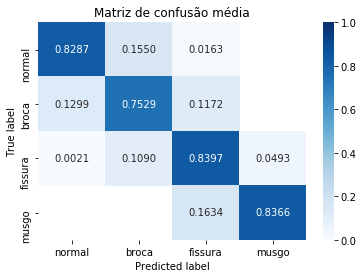

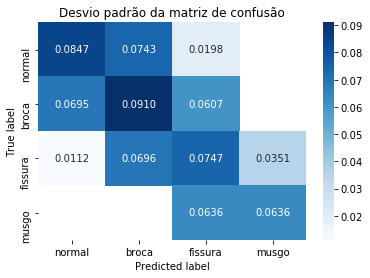

In [5]:
confusion_matrix_mean = np.mean(confu_matrices, axis=0)
confusion_matrix_std = np.std(confu_matrices, axis=0)

sns.heatmap(
    data=confusion_matrix_mean,
    cmap='Blues',
    vmin=0,
    vmax=1,
    annot=True,
    fmt='.4f',
    mask=confusion_matrix_mean == 0,
    xticklabels=TARGET_NAMES,
    yticklabels=TARGET_NAMES
    ).set(
        title='Matriz de confusão média',
        xlabel='Predicted label',
        ylabel='True label')

plt.show()

sns.heatmap(
    data=confusion_matrix_std,
    cmap='Blues',
    annot=True,
    fmt='.4f',
    mask=confusion_matrix_std == 0,
    xticklabels=TARGET_NAMES,
    yticklabels=TARGET_NAMES
    ).set(
        title='Desvio padrão da matriz de confusão',
        xlabel='Predicted label',
        ylabel='True label')

None

        Acurácia  f1-normal   f1-broca  f1-fissura   f1-musgo
count  30.000000  30.000000  30.000000   30.000000  30.000000
mean    0.813272   0.842090   0.745272    0.775239   0.885739
std     0.034223   0.063621   0.071843    0.043988   0.043849
min     0.740741   0.723404   0.583333    0.687500   0.780488
25%     0.796296   0.800000   0.707853    0.742726   0.860248
50%     0.814815   0.846806   0.719375    0.775510   0.888889
75%     0.833333   0.884625   0.790471    0.806876   0.920000
max     0.879630   0.952381   0.884615    0.857143   0.952381


Acurácia,f1-normal,f1-broca,f1-fissura,f1-musgo
0.805556,0.723404,0.714286,0.842105,0.928571
0.842593,0.900000,0.807018,0.793103,0.878049
0.768519,0.750000,0.583333,0.745098,0.927536
0.777778,0.800000,0.678571,0.750000,0.888889
0.833333,0.838710,0.708333,0.857143,0.920000
0.824074,0.903226,0.833333,0.723404,0.808511
0.787037,0.775510,0.714286,0.806452,0.857143
0.824074,0.846154,0.814815,0.823529,0.809524
0.842593,0.872727,0.836364,0.800000,0.857143
0.842593,0.905660,0.791667,0.760000,0.892308


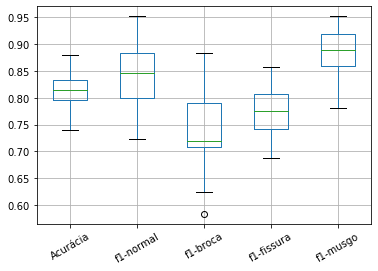

In [6]:
acc_df = pd.DataFrame(
  data=acc_e_f1_por_rodada,
  columns=['Acurácia'] + [f'f1-{name}' for name in TARGET_NAMES])

print(acc_df.describe())

acc_df.boxplot(rot=30)

acc_df.style.hide_index().background_gradient(cmap='Blues')